In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ucimlrepo import fetch_ucirepo
from scipy.stats import normaltest, levene, pointbiserialr, spearmanr, chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib.ticker import ScalarFormatter
from pandas.api.types import CategoricalDtype

### Resumen del caso de estudio

El conjunto “Default of Credit Card Clients” agrupa 30 000 registros de clientes de tarjetas en Taiwán, con variables demográficas (sexo, educación, estado civil, edad), límite de crédito, seis meses de historial de pagos y montos facturados/pagados. Este dataset proviene del UCI Machine Learning Repository (ID 350). La proporción de clases es aproximadamente 22 % de incumplimiento y 78 % de pago. Su propósito es analizar patrones que anticipen quién dejará de pagar al mes siguiente.

### Objetivo del modelo
Formular un clasificador binario que prediga la variable Y (“default next month”: 1 = incumplimiento, 0 = pago), de modo que la entidad financiera pueda ajustar políticas de crédito, provisiones y cobros de forma proactiva.

### Métrica objetivo: Recall de “incumplimiento de pago”

Maximizar el recall (TP / [TP + FN]) asegura detectar la mayor proporción posible de impagos reales. Dado que pasar por alto un incumplimiento genera pérdidas financieras directas muy superiores al coste de falsear un buen cliente, priorizar la sensibilidad es la estrategia más alineada con la gestión de riesgo crediticio.

In [196]:
# Accediendo al repositorio 

dccc = fetch_ucirepo(id=350)

# Accediendo a la información del dataset

data = dccc['data']

# Accediendo a las variables del dataset

df_dccc  = data['original']  # DataFrame con todas las variables + Y

# Mostrando las primeras filas del DataFrame

df_dccc.head(15)



,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [197]:
# Renombrar las columnas del DataFrame para que sean más legibles


# Primero, definimos un diccionario con el mapeo de nombres:
renombrar = {
    'ID':    'cliente_id',
    'X1':    'monto_credito',               # Monto del crédito otorgado
    'X2':    'genero',                      # Género: 1=hombre, 2=mujer
    'X3':    'nivel_educacion',             # Educación: 1=posgrado,2=universidad,3=secundaria,4=otros
    'X4':    'estado_civil',                # 1=casado,2=soltero,3=otros
    'X5':    'edad',                        # Edad en años
    # Historial de pagos: septiembre a abril 2005
    'X6':    'pago_sep2005',                
    'X7':    'pago_ago2005',
    'X8':    'pago_jul2005',
    'X9':    'pago_jun2005',
    'X10':   'pago_may2005',
    'X11':   'pago_abr2005',
    # Montos de factura: septiembre a abril 2005
    'X12':   'factura_sep2005',
    'X13':   'factura_ago2005',
    'X14':   'factura_jul2005',
    'X15':   'factura_jun2005',
    'X16':   'factura_may2005',
    'X17':   'factura_abr2005',
    # Montos pagados: septiembre a abril 2005
    'X18':   'pagado_sep2005',
    'X19':   'pagado_ago2005',
    'X20':   'pagado_jul2005',
    'X21':   'pagado_jun2005',
    'X22':   'pagado_may2005',
    'X23':   'pagado_abr2005',
    'Y':     'incumplimiento'               # 1 = default, 0 = pago
}

# Aplica el renombrado
df_dccc = df_dccc.rename(columns=renombrar)

# Verifica el resultado
df_dccc.head(15)


,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,...,factura_jun2005,factura_may2005,factura_abr2005,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005,incumplimiento
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [198]:
# Inspeccionando dimensiones del DataFrame

n_rows, n_cols = df_dccc.shape
print(f"Filas: {n_rows}, Columnas: {n_cols}")


Filas: 30000, Columnas: 25


In [199]:
# Validando el tipo de datos de cada columna

df_dccc.dtypes

cliente_id         int64
monto_credito      int64
genero             int64
nivel_educacion    int64
estado_civil       int64
edad               int64
pago_sep2005       int64
pago_ago2005       int64
pago_jul2005       int64
pago_jun2005       int64
pago_may2005       int64
pago_abr2005       int64
factura_sep2005    int64
factura_ago2005    int64
factura_jul2005    int64
factura_jun2005    int64
factura_may2005    int64
factura_abr2005    int64
pagado_sep2005     int64
pagado_ago2005     int64
pagado_jul2005     int64
pagado_jun2005     int64
pagado_may2005     int64
pagado_abr2005     int64
incumplimiento     int64
dtype: object

In [200]:
# Identificando valores nulos en el DataFrame

df_dccc.isnull().sum()



cliente_id         0
monto_credito      0
genero             0
nivel_educacion    0
estado_civil       0
edad               0
pago_sep2005       0
pago_ago2005       0
pago_jul2005       0
pago_jun2005       0
pago_may2005       0
pago_abr2005       0
factura_sep2005    0
factura_ago2005    0
factura_jul2005    0
factura_jun2005    0
factura_may2005    0
factura_abr2005    0
pagado_sep2005     0
pagado_ago2005     0
pagado_jul2005     0
pagado_jun2005     0
pagado_may2005     0
pagado_abr2005     0
incumplimiento     0
dtype: int64

In [201]:
# Identificando posibles valores duplicados en el DataFrame

df_dccc.duplicated().sum()

np.int64(0)

In [202]:
# Asignando nombres a las variables categóricas

# Crear copia del DataFrame original
df_limpio = df_dccc.copy(deep=True)

# Mapas para variables categóricas simples, con fillna para códigos no contemplados
map_genero = {1: 'hombre', 2: 'mujer'}
df_limpio['genero'] = df_limpio['genero'] \
    .map(map_genero) \
    .fillna('desconocido')

map_educacion = {1: 'posgrado', 2: 'universidad', 3: 'secundaria', 4: 'otros'}
df_limpio['nivel_educacion'] = df_limpio['nivel_educacion'] \
    .map(map_educacion) \
    .fillna('desconocido')

map_estado_civil = {1: 'casado', 2: 'soltero', 3: 'otros'}
df_limpio['estado_civil'] = df_limpio['estado_civil'] \
    .map(map_estado_civil) \
    .fillna('desconocido')

# Mantener la variable numérica original y crear una versión texto para reporting
map_incumplimiento = {0: 'no incumple', 1: 'incumple'}
df_limpio['incumplimiento_txt'] = df_limpio['incumplimiento'] \
    .map(map_incumplimiento)

# Mapeo del historial de pagos: conservar columnas originales y crear versiones textuales
map_historial_pago = {
    -2: 'pago adelantado',
    -1: 'pago puntual',
     0: 'pago pendiente'
}
map_historial_pago.update({i: f'retraso {i} meses' for i in range(1, 10)})

cols_hist = [
    'pago_sep2005', 'pago_ago2005', 'pago_jul2005',
    'pago_jun2005', 'pago_may2005', 'pago_abr2005'
]

for col in cols_hist:
    df_limpio[f'{col}_txt'] = df_limpio[col] \
        .map(map_historial_pago) \
        .fillna('desconocido')

# Verificación
df_limpio.head(15)


,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,...,pagado_may2005,pagado_abr2005,incumplimiento,incumplimiento_txt,pago_sep2005_txt,pago_ago2005_txt,pago_jul2005_txt,pago_jun2005_txt,pago_may2005_txt,pago_abr2005_txt
0,1,20000,mujer,universidad,casado,24,2,2,-1,-1,...,0,0,1,incumple,retraso 2 meses,retraso 2 meses,pago puntual,pago puntual,pago adelantado,pago adelantado
1,2,120000,mujer,universidad,soltero,26,-1,2,0,0,...,0,2000,1,incumple,pago puntual,retraso 2 meses,pago pendiente,pago pendiente,pago pendiente,retraso 2 meses
2,3,90000,mujer,universidad,soltero,34,0,0,0,0,...,1000,5000,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
3,4,50000,mujer,universidad,casado,37,0,0,0,0,...,1069,1000,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
4,5,50000,hombre,universidad,casado,57,-1,0,-1,0,...,689,679,0,no incumple,pago puntual,pago pendiente,pago puntual,pago pendiente,pago pendiente,pago pendiente
5,6,50000,hombre,posgrado,soltero,37,0,0,0,0,...,1000,800,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
6,7,500000,hombre,posgrado,soltero,29,0,0,0,0,...,13750,13770,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
7,8,100000,mujer,universidad,soltero,23,0,-1,-1,0,...,1687,1542,0,no incumple,pago pendiente,pago puntual,pago puntual,pago pendiente,pago pendiente,pago puntual
8,9,140000,mujer,secundaria,casado,28,0,0,2,0,...,1000,1000,0,no incumple,pago pendiente,pago pendiente,retraso 2 meses,pago pendiente,pago pendiente,pago pendiente
9,10,20000,hombre,secundaria,soltero,35,-2,-2,-2,-2,...,1122,0,0,no incumple,pago adelantado,pago adelantado,pago adelantado,pago adelantado,pago puntual,pago puntual


In [203]:
# Tipos de datos de cada columna

print("\n>>> TIPOS DE DATOS:")
print(df_limpio.dtypes)



>>> TIPOS DE DATOS:
cliente_id             int64
monto_credito          int64
genero                object
nivel_educacion       object
estado_civil          object
edad                   int64
pago_sep2005           int64
pago_ago2005           int64
pago_jul2005           int64
pago_jun2005           int64
pago_may2005           int64
pago_abr2005           int64
factura_sep2005        int64
factura_ago2005        int64
factura_jul2005        int64
factura_jun2005        int64
factura_may2005        int64
factura_abr2005        int64
pagado_sep2005         int64
pagado_ago2005         int64
pagado_jul2005         int64
pagado_jun2005         int64
pagado_may2005         int64
pagado_abr2005         int64
incumplimiento         int64
incumplimiento_txt    object
pago_sep2005_txt      object
pago_ago2005_txt      object
pago_jul2005_txt      object
pago_jun2005_txt      object
pago_may2005_txt      object
pago_abr2005_txt      object
dtype: object


In [204]:
# Estadísticas descriptivas de variables numéricas

# Seleccionando solo numéricas de entrada, excluyendo ID y target
num_cols = (
    df_limpio
    .select_dtypes(include='number')
    .columns
    .drop(['cliente_id', 'incumplimiento'])
)
num_df = df_limpio[num_cols]

# Estadísticos básicos y shape
desc = num_df.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T

# Sesgo y curtosis
desc['skewness'] = num_df.skew()
desc['kurtosis'] = num_df.kurtosis()

# Presentación: transponer para que cada estadístico sea fila
stats = desc.T

print("\n>>> ESTADÍSTICAS DESCRIPTIVAS (numéricas) + Skewness, Kurtosis & Outlier Percentiles:")
display(stats)



>>> ESTADÍSTICAS DESCRIPTIVAS (numéricas) + Skewness, Kurtosis & Outlier Percentiles:


,monto_credito,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,pago_may2005,pago_abr2005,factura_sep2005,factura_ago2005,factura_jul2005,factura_jun2005,factura_may2005,factura_abr2005,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.681500,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.961470,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1%,10000.000000,22.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-81.000000,-200.000000,-2.000000e+02,-212.020000,-232.010000,-331.030000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.000000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.000000,4013.250000,4031.500000,4000.000000
99%,500000.000000,60.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,350110.680000,337495.280000,3.250304e+05,304997.270000,285868.330000,279505.060000,66522.180000,7.665102e+04,70000.000000,67054.440000,65607.560000,82619.050000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


In [205]:
# Estadísticas descriptivas de variables categóricas

cat_cols = [
    'genero',
    'nivel_educacion',
    'estado_civil',
    'incumplimiento_txt',
    'pago_sep2005_txt',
    'pago_ago2005_txt',
    'pago_jul2005_txt',
    'pago_jun2005_txt',
    'pago_may2005_txt',
    'pago_abr2005_txt'
]

df_cat = df_limpio[cat_cols]

# Describe básico
desc_cat = df_cat.describe().T

# Añadir conteo y porcentaje de nulos
n_nulos = df_cat.isnull().sum()
p_nulos = (n_nulos / len(df_cat) * 100).round(2)
desc_cat['nulos']   = n_nulos
desc_cat['% nulos'] = p_nulos

print("\n>>> RESUMEN DE CATEGÓRICAS (incluye historiales de pago):")
display(desc_cat)




>>> RESUMEN DE CATEGÓRICAS (incluye historiales de pago):


,count,unique,top,freq,nulos,% nulos
genero,30000,2,mujer,18112,0,0.0
nivel_educacion,30000,5,universidad,14030,0,0.0
estado_civil,30000,4,soltero,15964,0,0.0
incumplimiento_txt,30000,2,no incumple,23364,0,0.0
pago_sep2005_txt,30000,11,pago pendiente,14737,0,0.0
pago_ago2005_txt,30000,11,pago pendiente,15730,0,0.0
pago_jul2005_txt,30000,11,pago pendiente,15764,0,0.0
pago_jun2005_txt,30000,11,pago pendiente,16455,0,0.0
pago_may2005_txt,30000,10,pago pendiente,16947,0,0.0
pago_abr2005_txt,30000,10,pago pendiente,16286,0,0.0


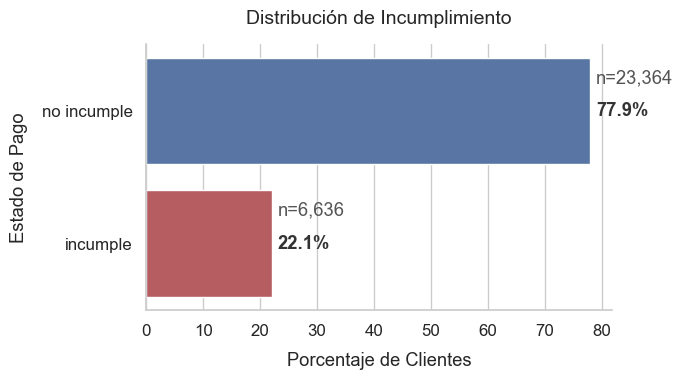

In [206]:
# Distribución de la variable objetivo con porcentajes


# Configurar estilo general
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top']   = False

# Preparar datos de conteo y porcentaje
counts = (
    df_limpio['incumplimiento_txt']
    .value_counts()
    .reindex(['no incumple', 'incumple'])
)
perc = (counts / counts.sum() * 100).round(1)

# Crear DataFrame para seaborn
df_plot = perc.reset_index()
df_plot.columns = ['estado', 'percentage']

# Gráfico de barras horizontal con hue
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    data=df_plot,
    x='percentage',
    y='estado',
    hue='estado',
    palette=['#4C72B0', '#C44E52'],
    dodge=False,
    ax=ax
)

# Eliminar leyenda sólo si existe
legend = ax.get_legend()
if legend is not None:
    legend.remove()

# Anotar porcentajes y totales
for i, (p, c) in enumerate(zip(df_plot['percentage'], counts.values)):
    ax.text(
        p + 1, i,
        f"{p:.1f}%",
        va='center',
        color='#333333',
        fontweight='bold'
    )
    ax.text(
        p + 1, i - 0.25,
        f"n={c:,}",
        va='center',
        color='#555555'
    )

# Títulos y etiquetas
ax.set_title("Distribución de Incumplimiento", pad=15, fontsize=14)
ax.set_xlabel("Porcentaje de Clientes", labelpad=10)
ax.set_ylabel("Estado de Pago", labelpad=10)

plt.tight_layout()
plt.show()


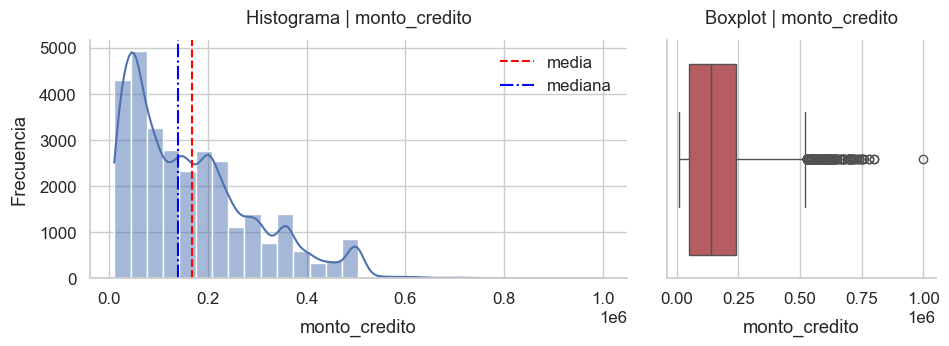

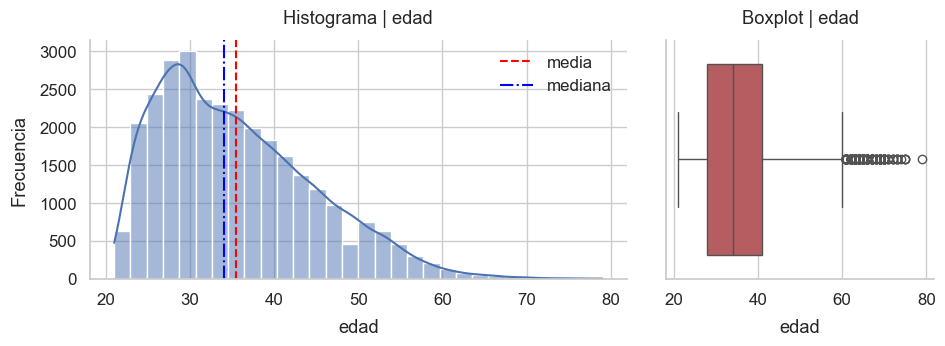

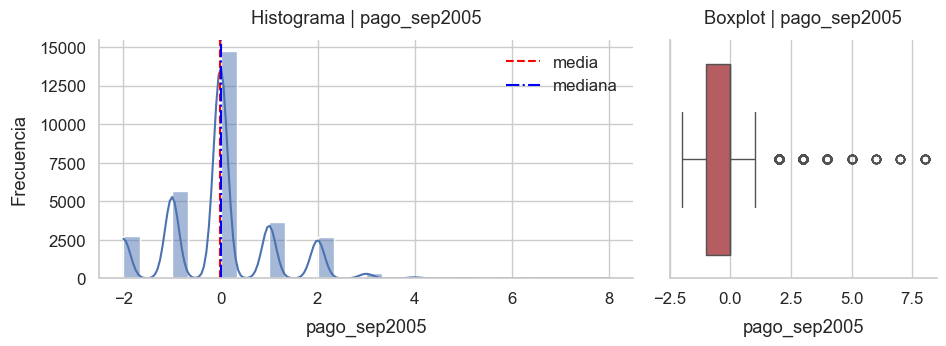

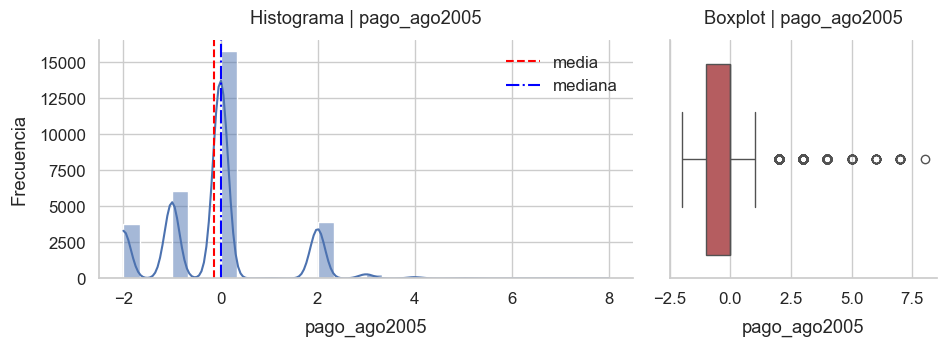

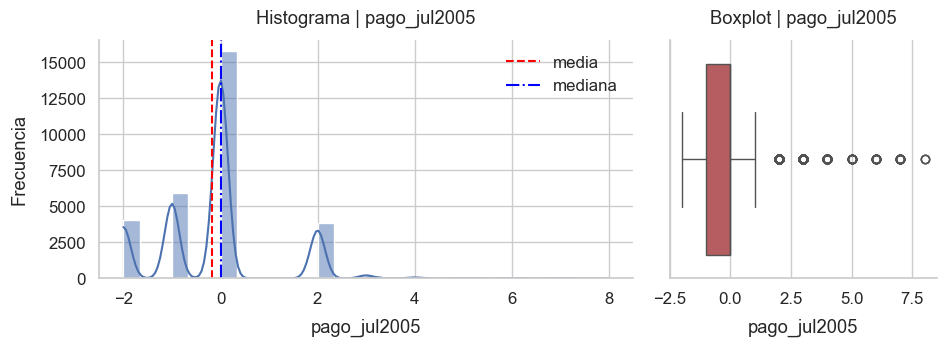

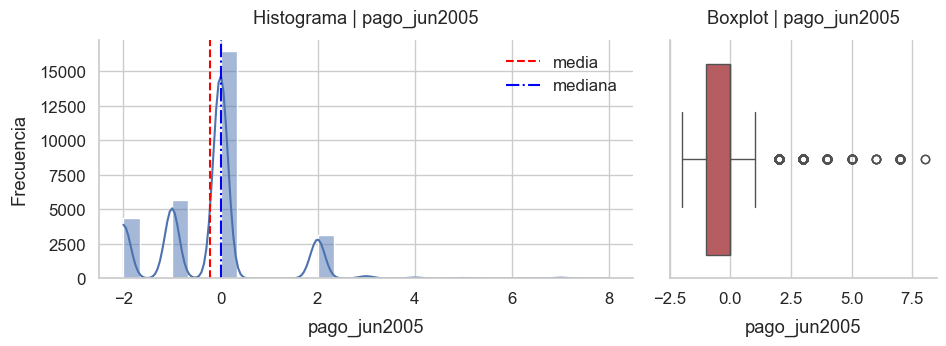

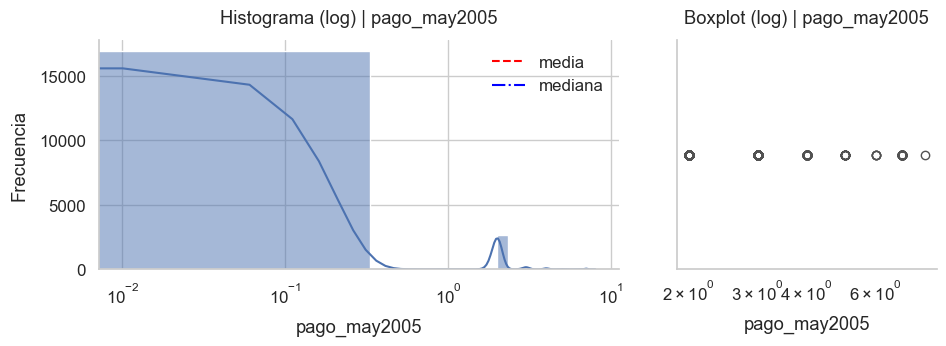

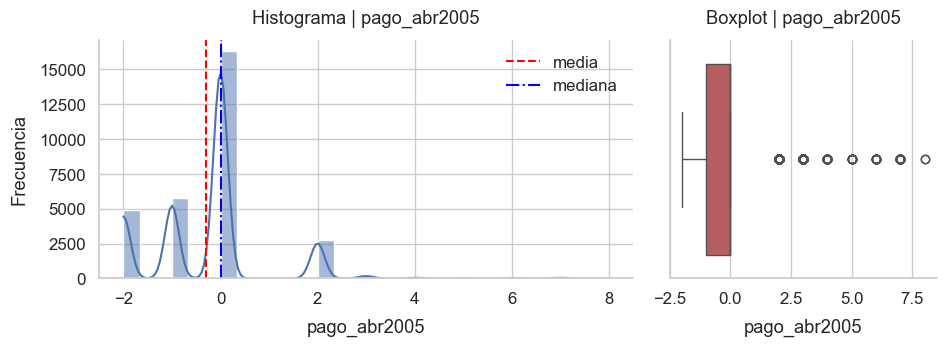

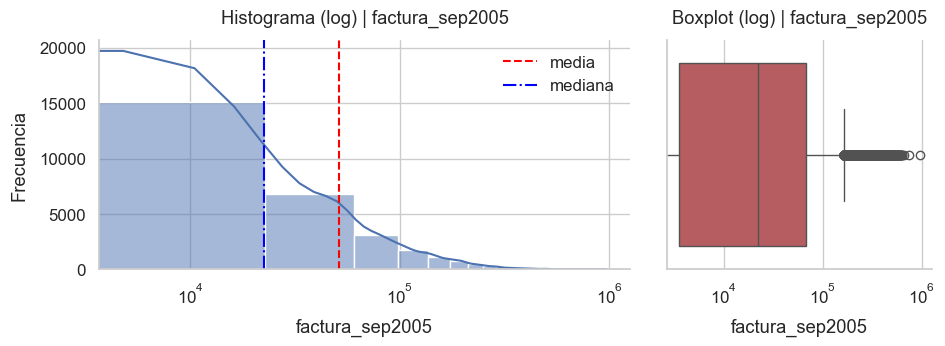

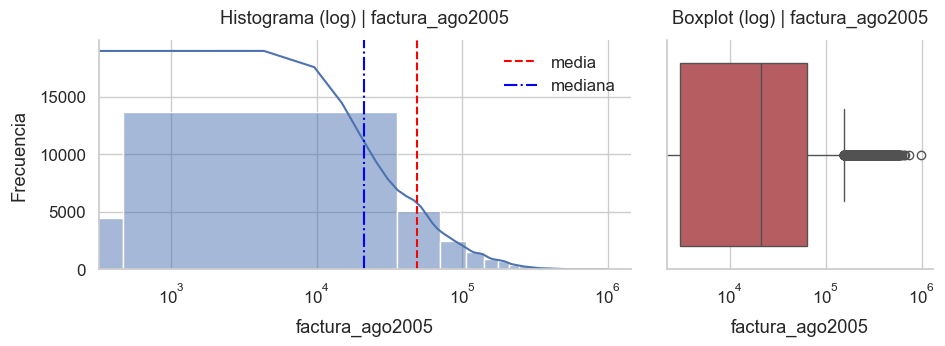

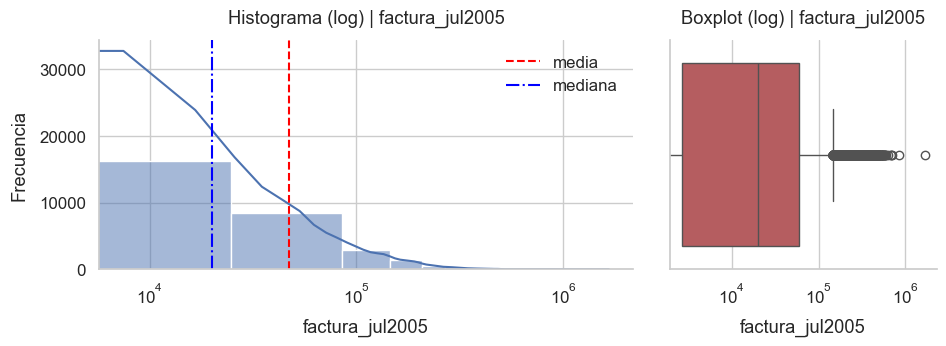

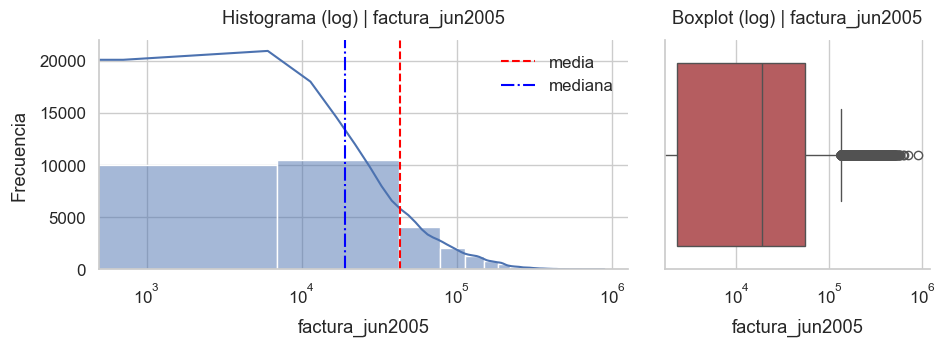

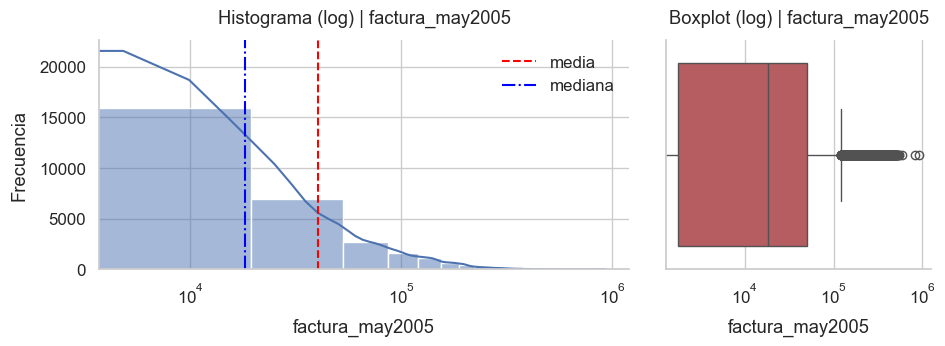

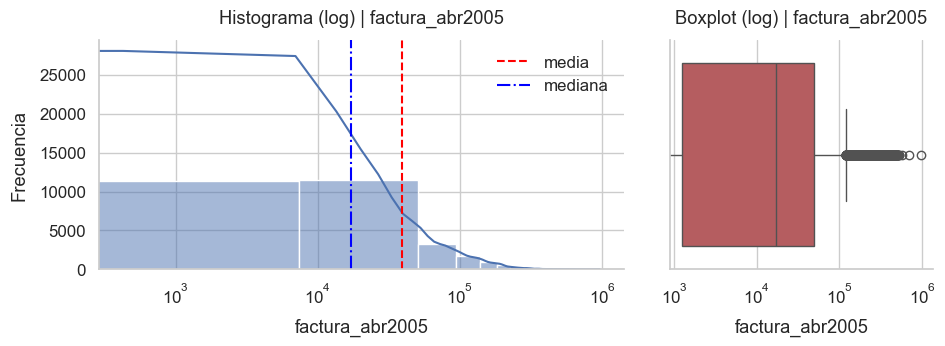

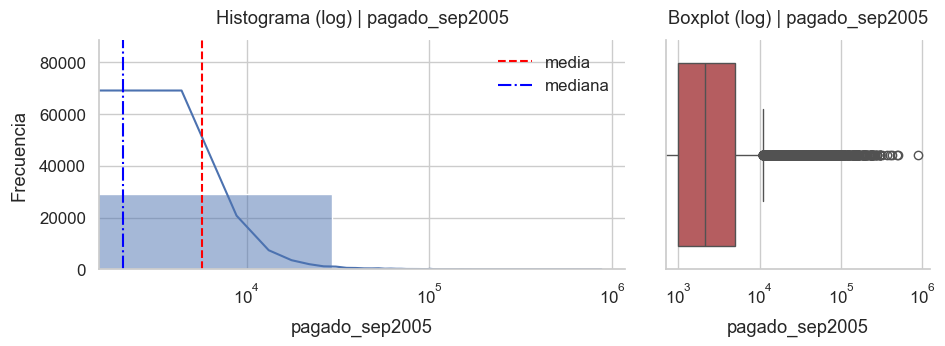

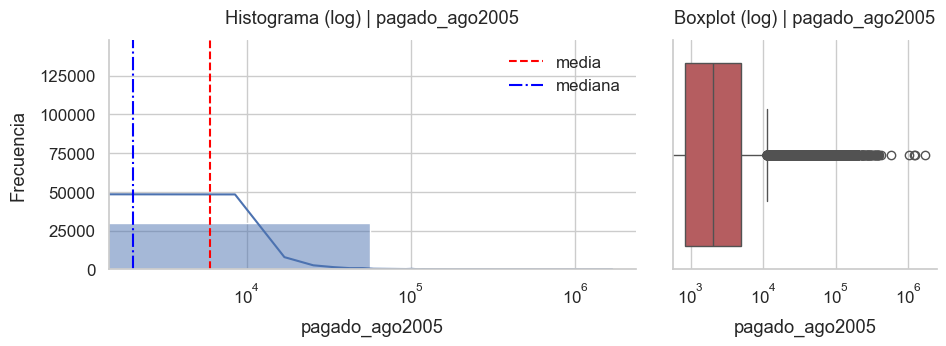

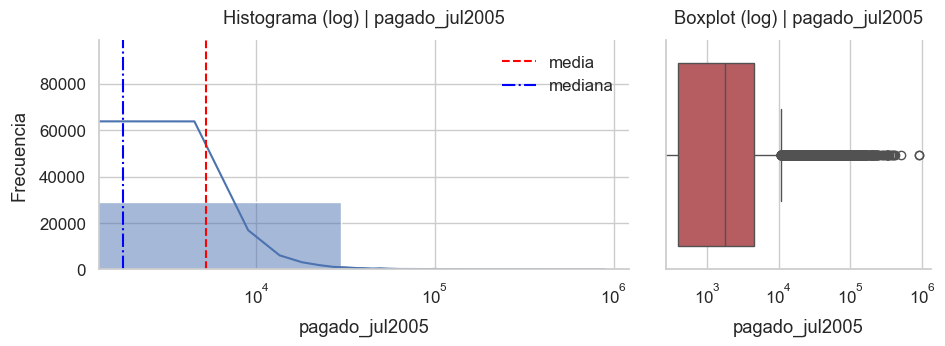

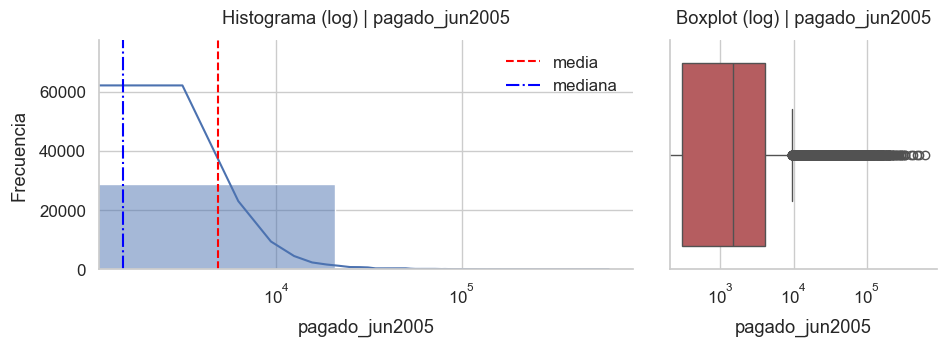

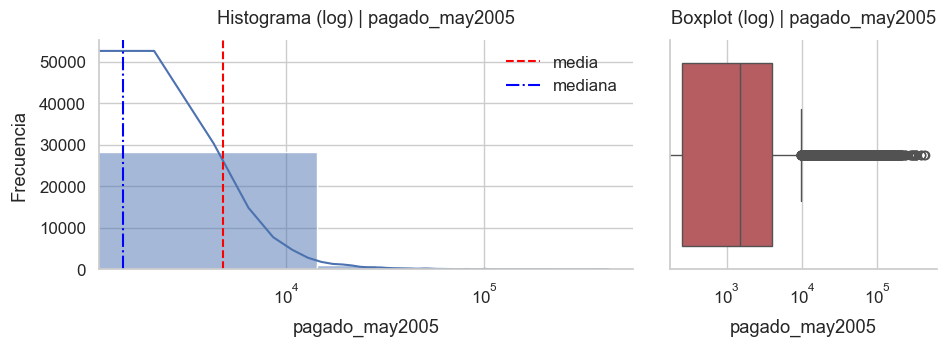

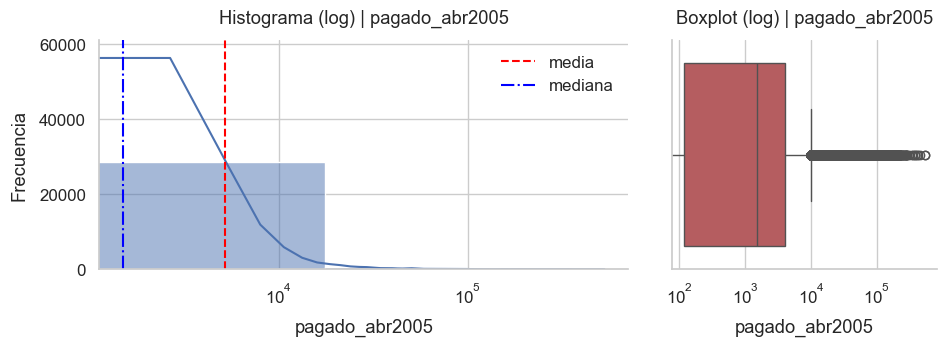

In [207]:
# Análisis univariado de variables numéricas

# Estilo general
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False

# Separar target y features
y = df_limpio['incumplimiento']
X = df_limpio.drop(columns=['incumplimiento','cliente_id'])

# Seleccionar variables numéricas
num_vars = X.select_dtypes(include='number').columns

# Loop con criterios de visualización
for col in num_vars:
    series = X[col]
    skewness = series.skew()
    use_log = abs(skewness) > 1  # aplicar log si skew > 1

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
    
    # Histograma + KDE
    ax0 = axes[0]
    sns.histplot(series, bins=30, kde=True, ax=ax0, color='#4C72B0', edgecolor='white')
    ax0.set_title(f'Histograma | {col}', pad=12)
    ax0.set_xlabel(col, labelpad=8)
    ax0.set_ylabel('Frecuencia', labelpad=8)
    # Líneas de media y mediana
    ax0.axvline(series.mean(), color='red', linestyle='--', linewidth=1.5, label='media')
    ax0.axvline(series.median(), color='blue', linestyle='-.', linewidth=1.5, label='mediana')
    ax0.legend(frameon=False, loc='upper right')
    # Escala log si está muy sesgado
    if use_log:
        ax0.set_xscale('log')
        ax0.set_title(f'Histograma (log) | {col}', pad=12)
    
    # Boxplot horizontal
    ax1 = axes[1]
    sns.boxplot(x=series, ax=ax1, color='#C44E52')
    ax1.set_title(f'Boxplot | {col}', pad=12)
    ax1.set_xlabel(col, labelpad=8)
    if use_log:
        ax1.set_xscale('log')
        ax1.set_title(f'Boxplot (log) | {col}', pad=12)

    plt.tight_layout(pad=2)
    plt.show()


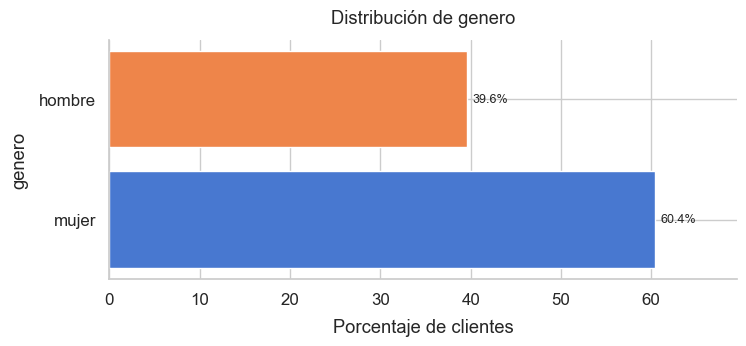

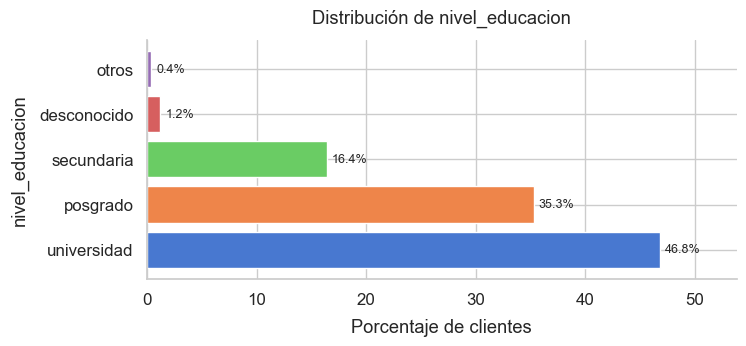

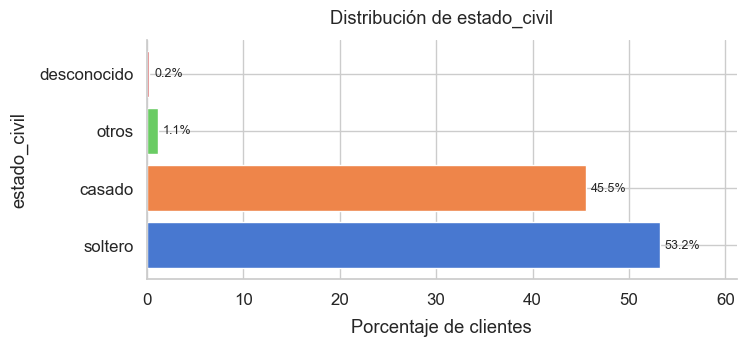

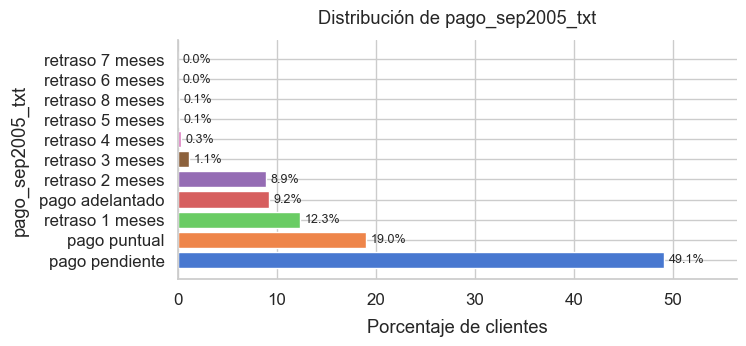

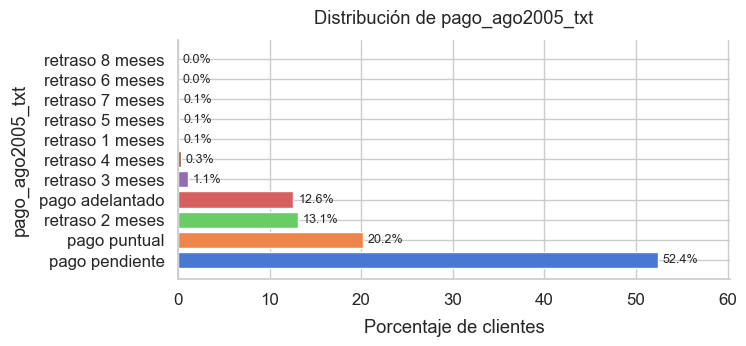

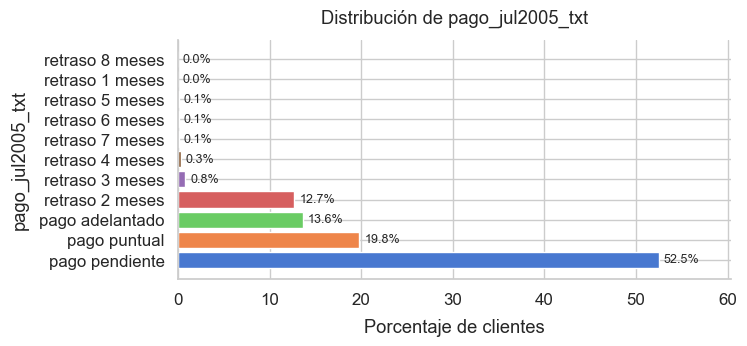

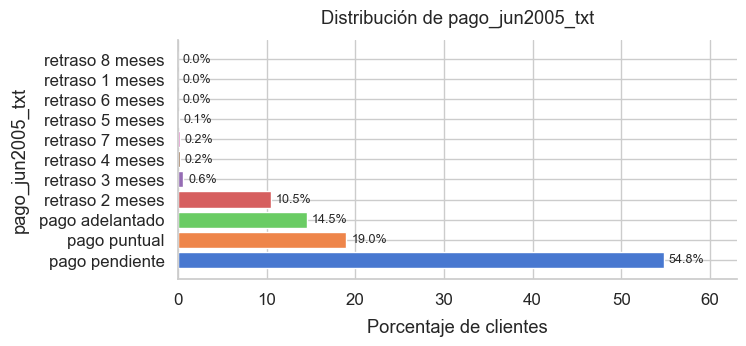

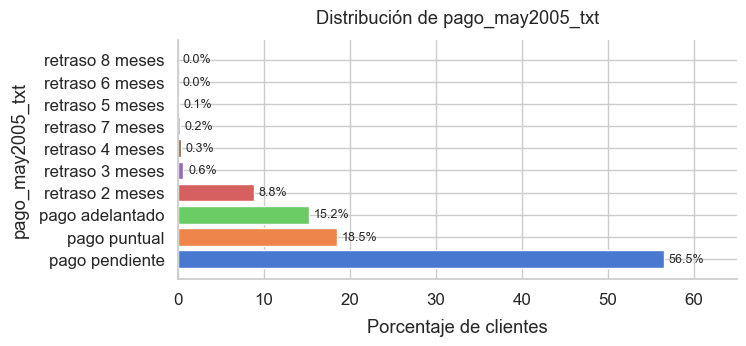

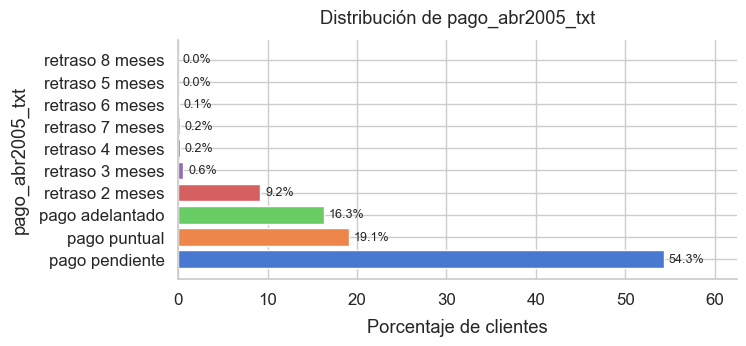

In [208]:
# Análisis univariado categórico

# Estilo limpio y uniforme
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False

# Seleccionando variables categóricas, excluyendo el target textual
cat_vars = [
    col for col in df_limpio.select_dtypes(include='object').columns
    if col != 'incumplimiento_txt'
]

# Loop de visualización univariada
for col in cat_vars:
    counts = df_limpio[col].value_counts(dropna=False)    # conteos absolutos
    pct    = (counts / counts.sum() * 100).round(1)       # convertir a porcentaje

    # Colores: uno por categoría, extraídos de la paleta 'muted'
    colors = sns.color_palette("muted", len(pct))      # lista de colores

    # Graficando barras horizontales
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(pct.index, pct.values, color=colors)

    # Anotar cada barra con su porcentaje
    for i, v in enumerate(pct.values):
        ax.text(
            v + pct.max() * 0.01, i, f"{v:.1f}%",     # ligero offset hacia la derecha
            va='center', fontsize=9
        )

    # Etiquetas y estética
    ax.set_title(f"Distribución de {col}", pad=12)
    ax.set_xlabel("Porcentaje de clientes", labelpad=8)
    ax.set_ylabel(col, labelpad=8)
    ax.set_xlim(0, pct.max() * 1.15)

    plt.tight_layout(pad=2)
    plt.show()


In [209]:
# Validando cardinalidad y detección de niveles raros en variables categóricas


def reportar_cardinalidad_y_rareza(
    df: pd.DataFrame,
    cat_cols: list,
    target_col: str,
    umbral_rareza: float = 0.01
) -> pd.DataFrame:
    """
    Para cada variable categórica en cat_cols:
      - Calcula total de niveles (incluyendo NaN).
      - Detecta niveles con frecuencia < umbral_rareza.
      - Devuelve un DataFrame con 'variable', 'cardinalidad' y lista de 'niveles_raros'.
    """
    resultados = []

    for col in cat_cols:
        # Frecuencias absolutas y relativas (incluyendo NaN)
        freq_abs = df[col].value_counts(dropna=False)
        freq_rel = df[col].value_counts(normalize=True, dropna=False)
        
        # Cardinalidad (se cuenta NaN como nivel si está presente)
        card = freq_abs.shape[0]

        # Niveles raros (incluye NaN si freq < umbral)
        raros = freq_rel[freq_rel < umbral_rareza].index.tolist()
        
        resultados.append({
            'variable'       : col,
            'cardinalidad'   : card,
            'niveles_raros'  : raros or ['Ninguno']
        })

    return pd.DataFrame(resultados)

# Aplicando la función de rareza a las variables categóricas

# Identificar columnas categóricas
cat_vars = [
    c for c in df_limpio.select_dtypes(include='object').columns
    if c != 'incumplimiento_txt'
]

# Generar el reporte
df_rareza = reportar_cardinalidad_y_rareza(
    df       = df_limpio,
    cat_cols = cat_vars,
    target_col = 'incumplimiento_txt',
    umbral_rareza = 0.01
)

# Mostrarlo ordenado por mayor cardinalidad
print(df_rareza.sort_values('cardinalidad', ascending=False).to_string(index=False))



        variable  cardinalidad                                                                                                           niveles_raros
pago_ago2005_txt            11                  [retraso 4 meses, retraso 1 meses, retraso 5 meses, retraso 7 meses, retraso 6 meses, retraso 8 meses]
pago_jun2005_txt            11 [retraso 3 meses, retraso 4 meses, retraso 7 meses, retraso 5 meses, retraso 6 meses, retraso 1 meses, retraso 8 meses]
pago_sep2005_txt            11                                   [retraso 4 meses, retraso 5 meses, retraso 8 meses, retraso 6 meses, retraso 7 meses]
pago_jul2005_txt            11 [retraso 3 meses, retraso 4 meses, retraso 7 meses, retraso 6 meses, retraso 5 meses, retraso 1 meses, retraso 8 meses]
pago_may2005_txt            10                  [retraso 3 meses, retraso 4 meses, retraso 7 meses, retraso 5 meses, retraso 6 meses, retraso 8 meses]
pago_abr2005_txt            10                  [retraso 3 meses, retraso 4 meses, retraso 7 m

In [210]:
# Columnas de historial de pago (ordinales)

pago_cols = [
    'pago_sep2005', 'pago_ago2005', 'pago_jul2005',
    'pago_jun2005', 'pago_may2005', 'pago_abr2005'
]

# Asegurando valores numéricos y recortar outliers extremos
df_dccc[pago_cols] = (
    df_dccc[pago_cols]
      .apply(pd.to_numeric, errors='coerce')
      .clip(lower=-2, upper=3)   # agrupa <–2 y ≥3 en los extremos deseados
)

# Definiendo tipo ordinal para preservar orden, pero sin impedir agregaciones
cats = [-2, -1, 0, 1, 2, 3]
ord_dtype = pd.CategoricalDtype(categories=cats, ordered=True)
for col in pago_cols:
    df_dccc[col] = df_dccc[col].astype(ord_dtype)

# Feature: máximo retraso
df_dccc['max_retraso'] = df_dccc[pago_cols].max(axis=1)

# Feature: promedio de retrasos
df_dccc['prom_retraso'] = (
    df_dccc[pago_cols]
      .apply(lambda s: s.astype(int))  # recupera los valores numéricos reales
      .mean(axis=1)
      .astype('float32')
)

# Feature: tendencia (dot-product con pesos)
weights = np.arange(len(pago_cols))
norm    = weights.sum()
# Extraemos códigos y los convertimos de nuevo a la escala original:
code_df = df_dccc[pago_cols].apply(lambda s: s.cat.codes.replace({
    i: cats[i] for i in range(len(cats))
}))
df_dccc['tend_retraso'] = (code_df.dot(weights) / norm).astype('float32')

# 7) Verificación
print(
    df_dccc[pago_cols + 
            ['max_retraso', 'prom_retraso', 'tend_retraso']]
    .head(10)
)



  pago_sep2005 pago_ago2005 pago_jul2005 pago_jun2005 pago_may2005  \
0            2            2           -1           -1           -2   
1           -1            2            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4           -1            0           -1            0            0   
5            0            0            0            0            0   
6            0            0            0            0            0   
7            0           -1           -1            0            0   
8            0            0            2            0            0   
9           -2           -2           -2           -2           -1   

  pago_abr2005 max_retraso  prom_retraso  tend_retraso  
0           -2           2     -0.333333     -1.400000  
1            2           2      0.500000      0.800000  
2            0           0      0.000000      0.000000  
3

In [211]:
# Verificando valores únicos de pago_cols

for col in pago_cols:
    # Remover categorías no usadas
    df_dccc[col] = df_dccc[col].cat.remove_unused_categories()
    
    # Mostrar valores únicos y cardinalidad real
    print(f"\n>>> {col.upper()}")
    print("Valores únicos:", df_dccc[col].cat.categories.tolist())
    print(f"Cardinalidad: {df_dccc[col].nunique()} niveles")

    


>>> PAGO_SEP2005
Valores únicos: [-2, -1, 0, 1, 2, 3]
Cardinalidad: 6 niveles

>>> PAGO_AGO2005
Valores únicos: [-2, -1, 0, 1, 2, 3]
Cardinalidad: 6 niveles

>>> PAGO_JUL2005
Valores únicos: [-2, -1, 0, 1, 2, 3]
Cardinalidad: 6 niveles

>>> PAGO_JUN2005
Valores únicos: [-2, -1, 0, 1, 2, 3]
Cardinalidad: 6 niveles

>>> PAGO_MAY2005
Valores únicos: [-2, -1, 0, 2, 3]
Cardinalidad: 5 niveles

>>> PAGO_ABR2005
Valores únicos: [-2, -1, 0, 2, 3]
Cardinalidad: 5 niveles


In [212]:
# Aplicando mapeo a DataFrame original

# Definiendo diccionarios de mapeo
map_genero = {
    1: 'hombre',
    2: 'mujer'
}
map_educacion = {
    1: 'posgrado',
    2: 'universidad',
    3: 'secundaria',
    4: 'otros'
}
map_estado_civil = {
    1: 'casado',
    2: 'soltero',
    3: 'otros'
}
map_incumplimiento = {
    0: 'no incumple',
    1: 'incumple'
}

# Aplicando los mapeos y rellenar NaN con "desconocido"
df_dccc['genero'] = (
    df_dccc['genero']
      .map(map_genero)
      .fillna('desconocido')
)
df_dccc['nivel_educacion'] = (
    df_dccc['nivel_educacion']
      .map(map_educacion)
      .fillna('desconocido')
)
df_dccc['estado_civil'] = (
    df_dccc['estado_civil']
      .map(map_estado_civil)
      .fillna('desconocido')
)
df_dccc['incumplimiento_txt'] = (
    df_dccc['incumplimiento']
      .map(map_incumplimiento)
      .fillna('desconocido')
)

# Convertiendo a tipo 'category'
categorical_cols = ['genero', 'nivel_educacion', 'estado_civil', 'incumplimiento_txt']
for col in categorical_cols:
    df_dccc[col] = df_dccc[col].astype('category')

# Definiendo un orden lógico para nivel_educacion, incluyendo 'desconocido'
edu_order = CategoricalDtype(
    categories=['desconocido','otros','secundaria','universidad','posgrado'],
    ordered=True
)
df_dccc['nivel_educacion'] = df_dccc['nivel_educacion'].astype(edu_order)

# Verificación final
print(df_dccc[categorical_cols].info())
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print("Categorías:", df_dccc[col].cat.categories.tolist())
    print("Niveles observados:", df_dccc[col].nunique())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   genero              30000 non-null  category
 1   nivel_educacion     30000 non-null  category
 2   estado_civil        30000 non-null  category
 3   incumplimiento_txt  30000 non-null  category
dtypes: category(4)
memory usage: 118.0 KB
None

--- genero ---
Categorías: ['hombre', 'mujer']
Niveles observados: 2

--- nivel_educacion ---
Categorías: ['desconocido', 'otros', 'secundaria', 'universidad', 'posgrado']
Niveles observados: 5

--- estado_civil ---
Categorías: ['casado', 'desconocido', 'otros', 'soltero']
Niveles observados: 4

--- incumplimiento_txt ---
Categorías: ['incumple', 'no incumple']
Niveles observados: 2




===== monto_credito =====
                        n       mean        std    median      q25       q75  \
incumplimiento_txt                                                             
incumple             6636  130109.66  115378.54   90000.0  50000.0  200000.0   
no incumple         23364  178099.73  131628.36  150000.0  70000.0  250000.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


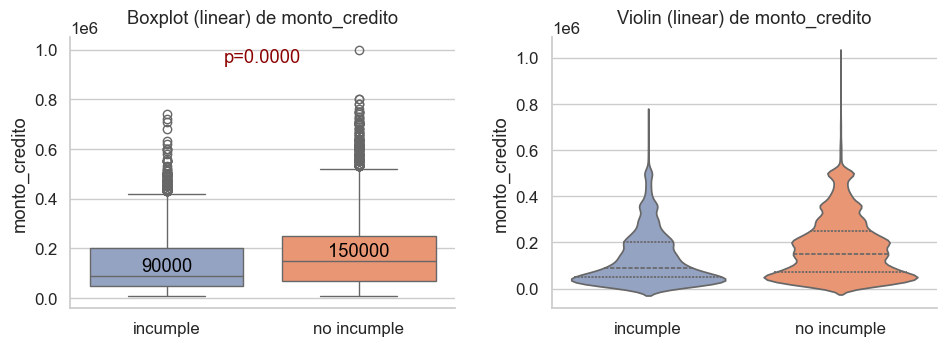



===== edad =====
                        n   mean   std  median   q25   q75            test  \
incumplimiento_txt                                                           
incumple             6636  35.73  9.69    34.0  28.0  42.0  Mann–Whitney U   
no incumple         23364  35.42  9.08    34.0  28.0  41.0  Mann–Whitney U   

                    p-value  
incumplimiento_txt           
incumple             0.3725  
no incumple          0.3725  


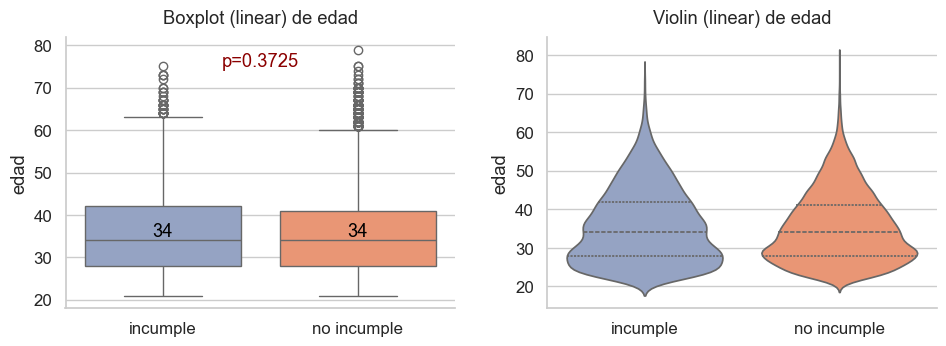



===== factura_sep2005 =====
                        n      mean       std   median      q25      q75  \
incumplimiento_txt                                                         
incumple             6636  48509.16  73782.07  20185.0  2987.75  59626.5   
no incumple         23364  51994.23  73577.61  23119.5  3677.25  69027.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


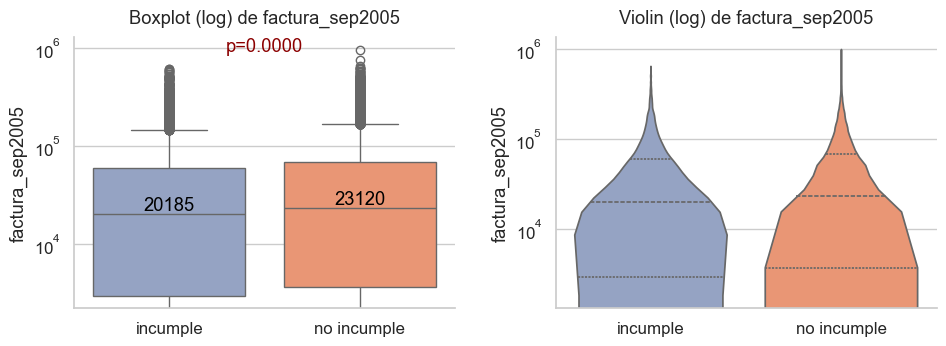



===== factura_ago2005 =====
                        n      mean       std   median     q25       q75  \
incumplimiento_txt                                                         
incumple             6636  47283.62  71651.03  20300.5  2694.0  57919.75   
no incumple         23364  49717.44  71029.95  21660.5  3055.0  65686.00   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.0071  
no incumple         Mann–Whitney U   0.0071  


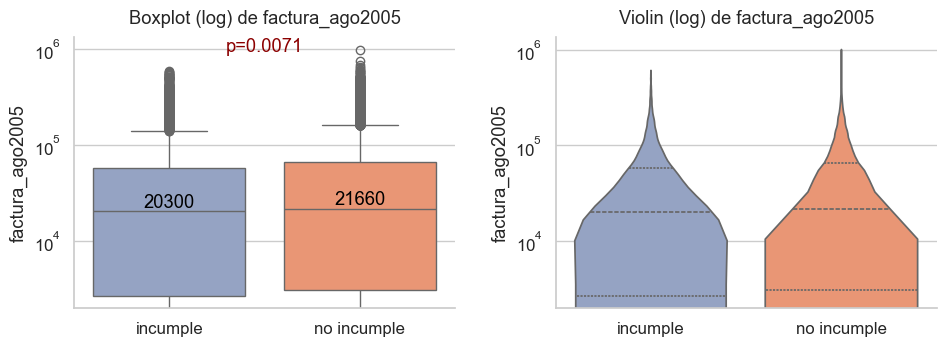



===== factura_jul2005 =====
                        n      mean       std   median      q25       q75  \
incumplimiento_txt                                                          
incumple             6636  45181.60  68516.98  19834.5  2500.00  54733.75   
no incumple         23364  47533.37  69576.66  20202.5  2769.75  61894.00   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.0282  
no incumple         Mann–Whitney U   0.0282  


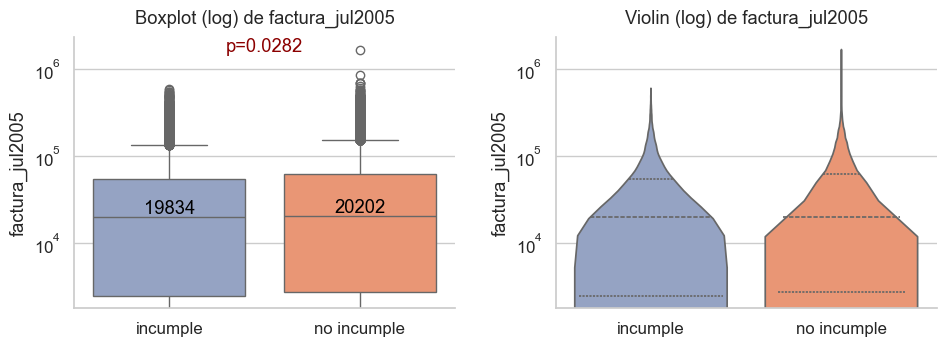



===== factura_jun2005 =====
                        n      mean       std   median     q25       q75  \
incumplimiento_txt                                                         
incumple             6636  42036.95  64351.08  19119.5  2141.5  50175.75   
no incumple         23364  43611.17  64324.80  19000.0  2360.0  55988.00   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.1478  
no incumple         Mann–Whitney U   0.1478  


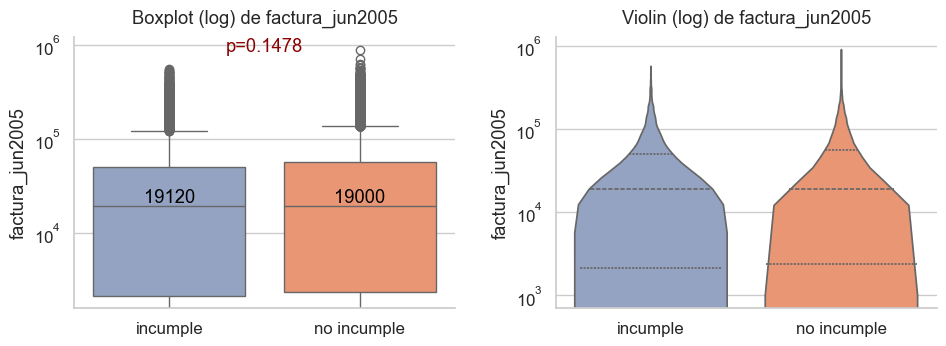



===== factura_may2005 =====
                        n      mean       std   median      q25       q75  \
incumplimiento_txt                                                          
incumple             6636  39540.19  61424.70  18478.5  1502.75  47853.00   
no incumple         23364  40530.45  60617.27  17998.0  1823.00  51135.25   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.2354  
no incumple         Mann–Whitney U   0.2354  


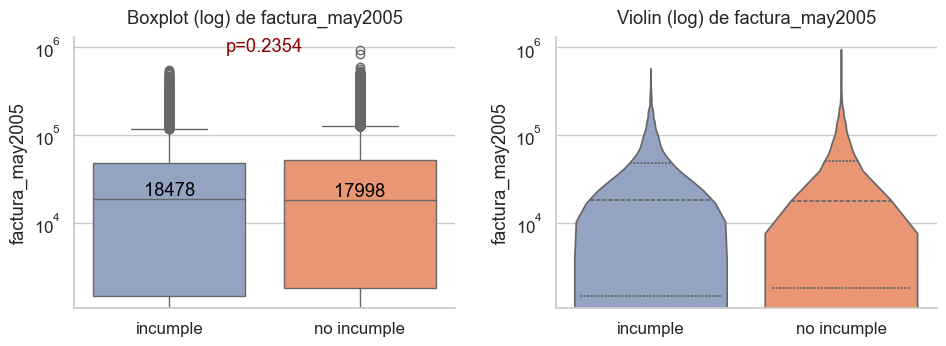



===== factura_abr2005 =====
                        n      mean       std   median     q25      q75  \
incumplimiento_txt                                                        
incumple             6636  38271.44  59579.67  18028.5  1150.0  47424.0   
no incumple         23364  39042.27  59547.02  16679.0  1265.5  49842.5   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.9895  
no incumple         Mann–Whitney U   0.9895  


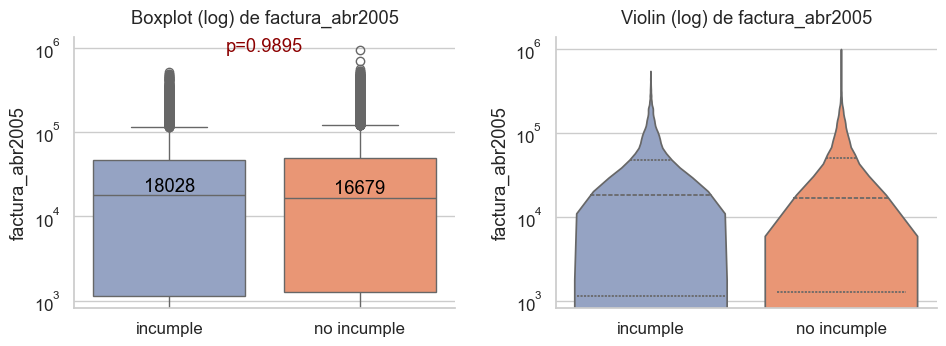



===== pagado_sep2005 =====
                        n     mean       std  median      q25      q75  \
incumplimiento_txt                                                       
incumple             6636  3397.04   9544.25  1636.0     0.00  3478.25   
no incumple         23364  6307.34  18014.51  2459.5  1163.75  5606.25   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


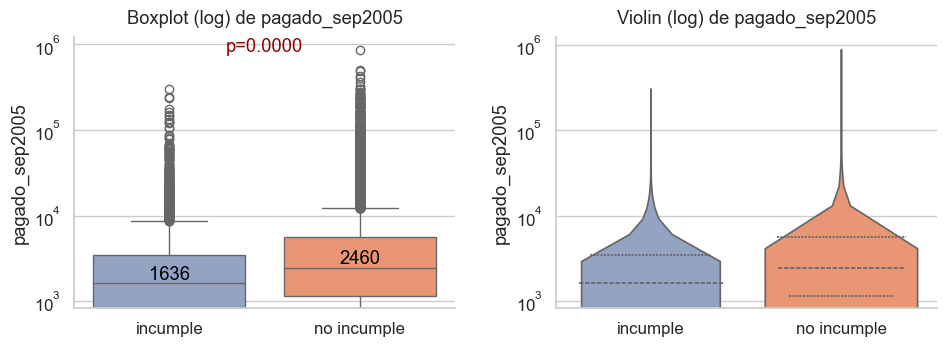



===== pagado_ago2005 =====
                        n     mean       std  median     q25      q75  \
incumplimiento_txt                                                      
incumple             6636  3388.65  11737.99  1533.5     0.0  3309.75   
no incumple         23364  6640.47  25302.26  2247.5  1005.0  5311.25   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


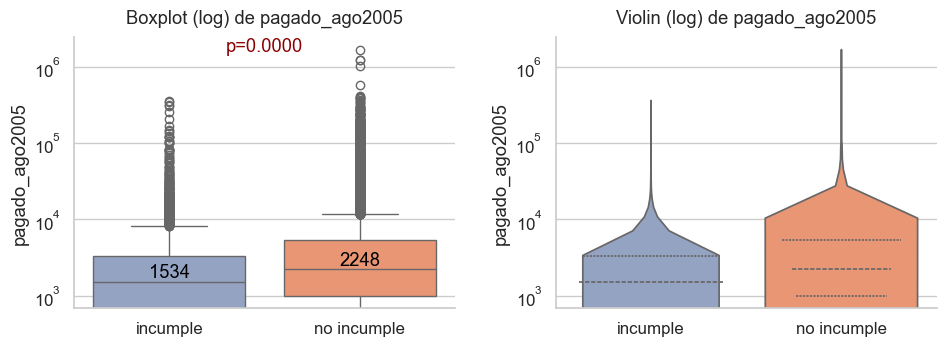



===== pagado_jul2005 =====
                        n     mean       std  median    q25     q75  \
incumplimiento_txt                                                    
incumple             6636  3367.35  12959.62  1222.0    0.0  3000.0   
no incumple         23364  5753.50  18684.26  2000.0  600.0  5000.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


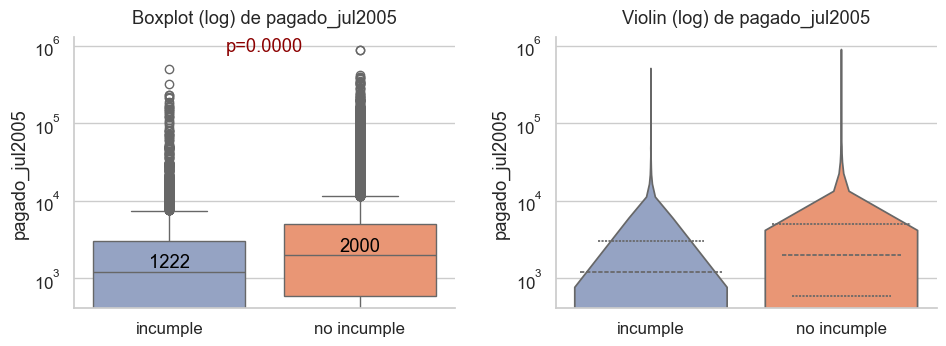



===== pagado_jun2005 =====
                        n     mean       std  median    q25      q75  \
incumplimiento_txt                                                     
incumple             6636  3155.63  11191.97  1000.0    0.0  2939.25   
no incumple         23364  5300.53  16689.78  1734.0  390.0  4602.00   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


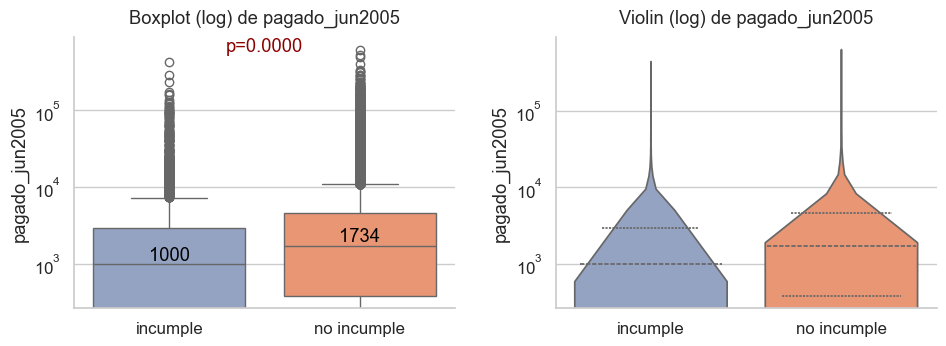



===== pagado_may2005 =====
                        n     mean       std  median    q25     q75  \
incumplimiento_txt                                                    
incumple             6636  3219.14  11944.73  1000.0    0.0  3000.0   
no incumple         23364  5248.22  16071.67  1765.0  369.0  4600.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


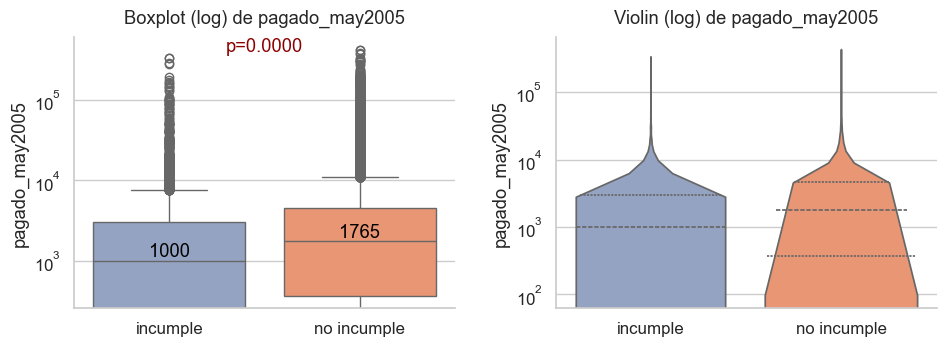



===== pagado_abr2005 =====
                        n     mean       std  median    q25     q75  \
incumplimiento_txt                                                    
incumple             6636  3441.48  13464.01  1000.0    0.0  2974.5   
no incumple         23364  5719.37  18792.95  1706.0  300.0  4545.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


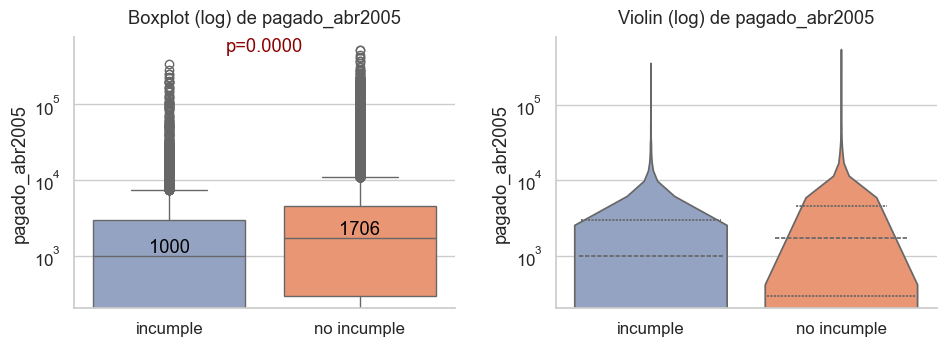



===== prom_retraso =====
                        n  mean   std  median   q25   q75            test  \
incumplimiento_txt                                                          
incumple             6636  0.30  1.15    0.33 -0.50  1.17  Mann–Whitney U   
no incumple         23364 -0.33  0.82    0.00 -0.83  0.00  Mann–Whitney U   

                    p-value  
incumplimiento_txt           
incumple                0.0  
no incumple             0.0  


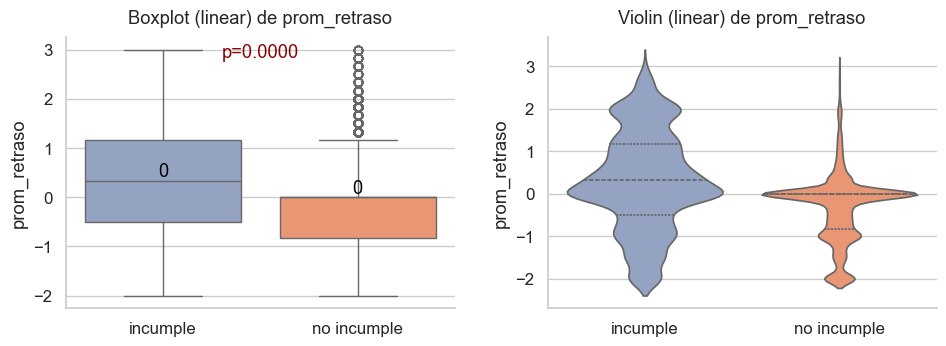



===== tend_retraso =====
                        n  mean   std  median  q25  q75            test  \
incumplimiento_txt                                                        
incumple             6636  0.17  1.22     0.0 -0.6  0.8  Mann–Whitney U   
no incumple         23364 -0.38  0.87     0.0 -1.0  0.0  Mann–Whitney U   

                    p-value  
incumplimiento_txt           
incumple                0.0  
no incumple             0.0  


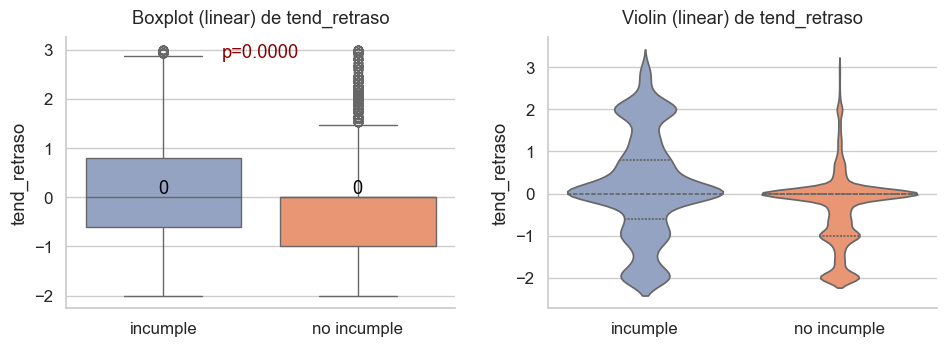

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, levene, mannwhitneyu, ttest_ind

# 1) Estilo global
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams.update({
    'axes.spines.top':   False,
    'axes.spines.right': False,
    'figure.dpi':        100
})

# 2) Resumen estadístico + test
def resumen_grupos(df, var, grupo_col='incumplimiento_txt'):
    g = df.groupby(grupo_col, observed=True)[var]
    stats = pd.DataFrame({
        'n':      g.size(),
        'mean':   g.mean(),
        'std':    g.std(),
        'median': g.median(),
        'q25':    g.quantile(0.25),
        'q75':    g.quantile(0.75)
    }).round(2)
    cats = stats.index.tolist()
    # normalidad
    p0 = normaltest(df[df[grupo_col]==cats[0]][var]).pvalue
    p1 = normaltest(df[df[grupo_col]==cats[1]][var]).pvalue
    # homogeneidad
    lev_p = levene(
        df[df[grupo_col]==cats[0]][var],
        df[df[grupo_col]==cats[1]][var]
    ).pvalue
    # elegir test
    if p0>0.05 and p1>0.05 and lev_p>0.05:
        stat, pval = ttest_ind(
            df[df[grupo_col]==cats[0]][var],
            df[df[grupo_col]==cats[1]][var],
            equal_var=True
        )
        test = 't-test'
    else:
        stat, pval = mannwhitneyu(
            df[df[grupo_col]==cats[0]][var],
            df[df[grupo_col]==cats[1]][var],
            alternative='two-sided'
        )
        test = 'Mann–Whitney U'
    stats['test']    = test
    stats['p-value'] = round(pval, 4)
    return stats

# 3) Plot comparativo sin warning
def plot_comparativo(df, var, grupo_col='incumplimiento_txt'):
    stats = resumen_grupos(df, var, grupo_col)
    pval_txt = f"p={stats['p-value'].iloc[0]:.4f}"
    skew = df[var].skew()
    scale = 'log' if abs(skew)>1 else 'linear'

    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    pal = ["#8DA0CB", "#FC8D62"]

    # — Boxplot —
    sns.boxplot(x=grupo_col, y=var, data=df,
                hue=grupo_col, palette=pal,
                dodge=False, ax=ax0)
    leg0 = ax0.get_legend()
    if leg0 is not None:
        leg0.remove()
    ax0.set_yscale(scale)
    ax0.set_title(f"Boxplot ({scale}) de {var}", pad=10)
    meds = df.groupby(grupo_col, observed=True)[var].median()
    for i, m in enumerate(meds):
        ax0.text(i, m, f"{m:.0f}", ha='center', va='bottom', color='black')
    ymax = df[var].max()
    ax0.text(0.5, 0.95*ymax, pval_txt, ha='center', color='darkred')

    # — Violinplot —
    sns.violinplot(x=grupo_col, y=var, data=df,
                   hue=grupo_col, palette=pal,
                   dodge=False, inner="quartile", ax=ax1)
    leg1 = ax1.get_legend()
    if leg1 is not None:
        leg1.remove()
    ax1.set_yscale(scale)
    ax1.set_title(f"Violin ({scale}) de {var}", pad=10)

    ax0.set_xlabel('')
    ax1.set_xlabel('')
    plt.tight_layout(pad=2)
    plt.show()

# 4) Aplicar a todas las variables numéricas
numeric_vars = df_dccc.select_dtypes(include='number')\
                      .columns.drop(['cliente_id','incumplimiento'])

for var in numeric_vars:
    print(f"\n\n===== {var} =====")
    print(resumen_grupos(df_dccc, var))
    plot_comparativo(df_dccc, var)





In [214]:
# Configuración

df = df_dccc.copy()          
target = 'incumplimiento'
id_col = 'cliente_id'


# Seleccionando variables numéricas (quitamos ID y target)
num_cols = df.select_dtypes(include='number').columns.drop([id_col, target])

resultados = []

for col in num_cols:
    g0 = df[df[target] == 0][col]
    g1 = df[df[target] == 1][col]
    

    # Validando Normalidad con prueba de (D’Agostino)
    s0 = g0.sample(5000, random_state=0) if len(g0) > 5000 else g0
    s1 = g1.sample(5000, random_state=0) if len(g1) > 5000 else g1
    _, p_norm0 = normaltest(s0)
    _, p_norm1 = normaltest(s1)
    
    # Homogeneidad de varianzas (Levene)
    _, p_levene = levene(g0, g1)
    
    normal   = (p_norm0 > 0.05) and (p_norm1 > 0.05)
    homosced =  p_levene > 0.05
    
    # Selección del método de correlación
    if normal and homosced:
        metodo = 'point-biserial (Pearson)'
        corr, p_corr = pointbiserialr(df[target], df[col])
    else:
        metodo = 'Spearman'
        corr, p_corr = spearmanr(df[target], df[col])
    
    resultados.append({
        'variable'       : col,
        'p_norm_grp0'    : round(p_norm0, 3),
        'p_norm_grp1'    : round(p_norm1, 3),
        'p_levene'       : round(p_levene, 3),
        'normal? (ambos)': normal,
        'homoscedástica?': homosced,
        'método'         : metodo,
        'correlación'    : round(corr, 3),
        'p_valor_corr'   : round(p_corr, 4)
    })

# Tabla de resultados ordenada por |correlación|
tabla = (pd.DataFrame(resultados)
           .set_index('variable')
           .reindex(columns=[
               'p_norm_grp0','p_norm_grp1','p_levene',
               'normal? (ambos)','homoscedástica?','método',
               'correlación','p_valor_corr'])
           .sort_values('correlación', key=lambda x: x.abs(), ascending=False))

tabla

,p_norm_grp0,p_norm_grp1,p_levene,normal? (ambos),homoscedástica?,método,correlación,p_valor_corr
variable,,,,,,,,
prom_retraso,0.0,0.0,0.000,False,False,Spearman,0.256,0.0000
tend_retraso,0.0,0.0,0.000,False,False,Spearman,0.215,0.0000
monto_credito,0.0,0.0,0.000,False,False,Spearman,-0.170,0.0000
pagado_sep2005,0.0,0.0,0.000,False,False,Spearman,-0.160,0.0000
pagado_ago2005,0.0,0.0,0.000,False,False,Spearman,-0.151,0.0000
pagado_jul2005,0.0,0.0,0.000,False,False,Spearman,-0.139,0.0000
pagado_jun2005,0.0,0.0,0.000,False,False,Spearman,-0.128,0.0000
pagado_abr2005,0.0,0.0,0.000,False,False,Spearman,-0.121,0.0000
pagado_may2005,0.0,0.0,0.000,False,False,Spearman,-0.117,0.0000


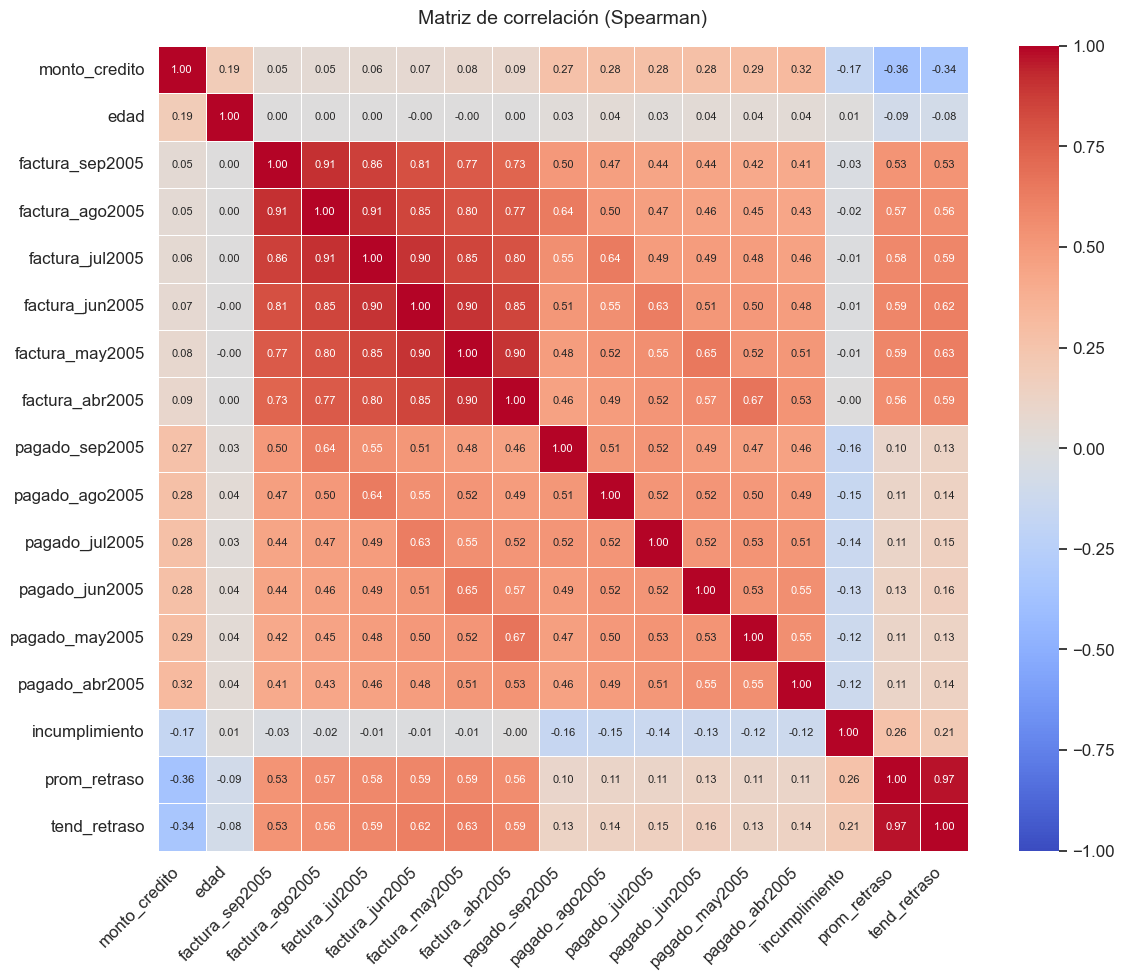

In [215]:
# Configuración de DataFrame para análisis de correlación

df = df_dccc.copy()
target = 'incumplimiento'
id_col = 'cliente_id'

# Seleccionando solo las columnas numéricas
num_df = df.select_dtypes(include='number').drop(columns=[id_col])

# Calculando matriz de correlación (Spearman recomendado)
corr = num_df.corr(method='spearman').round(2)


# Tamaño de la figura proporcional al nº de variables
fig, ax = plt.subplots(figsize=(12, 10))

# Heatmap con una paleta divergente centrada en 0
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={"size":8}
)

# Estética general
plt.title('Matriz de correlación (Spearman)', fontsize=14, pad=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [216]:
# Definiendo variables numéricas (excluyendo ID y target)

num_vars = df_dccc.select_dtypes(include='number').columns.drop(['cliente_id', 'incumplimiento'])

# Calculando AUC univariante para cada variable
auc_scores = {}
for col in num_vars:
    try:
        auc = roc_auc_score(df_dccc['incumplimiento'], df_dccc[col])
        auc_scores[col] = auc
    except ValueError:
        # En caso de variables constantes o problemas de cálculo
        auc_scores[col] = float('nan')

# Organizando resultados en un DataFrame ordenado
auc_df = (
    pd.Series(auc_scores, name='AUC')
      .sort_values(ascending=False)
      .to_frame()
      .round(3)
)

# Mostrando la tabla de AUCs
print(auc_df)


                   AUC
prom_retraso     0.675
tend_retraso     0.646
edad             0.504
factura_abr2005  0.500
factura_may2005  0.495
factura_jun2005  0.494
factura_jul2005  0.491
factura_ago2005  0.489
factura_sep2005  0.482
pagado_may2005   0.419
pagado_abr2005   0.416
pagado_jun2005   0.411
pagado_jul2005   0.403
pagado_ago2005   0.395
pagado_sep2005   0.389
monto_credito    0.382


In [217]:
# Definiendo variables categóricas (tipo object), sin incluir el target de texto
cat_vars = (df_dccc
            .select_dtypes(include='object')
            .columns
            .drop('incumplimiento_txt'))

# Función para calcular Cramér’s V
def cramers_v(ct):
    chi2, _, _, _ = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    k = min(ct.shape) - 1
    return np.sqrt(phi2 / k)

# Recorrer cada variable para χ² y Cramér’s V
resultados_chi2 = []
for col in cat_vars:
    # tabla de contingencia vs. target numérico
    ct = pd.crosstab(df_dccc[col], df_dccc['incumplimiento'])
    
    # prueba χ²
    chi2, p, _, _ = chi2_contingency(ct)
    
    # fuerza de asociación
    v = cramers_v(ct)
    
    resultados_chi2.append({
        'variable'    : col,
        'p_valor_χ²'  : round(p, 4),
        "Cramér's V"  : round(v, 3)
    })

# 4. DataFrame resumen ordenado por Cramér’s V
resumen_chi2 = (pd.DataFrame(resultados_chi2)
                  .set_index('variable')
                  .sort_values("Cramér's V", ascending=False))

print(resumen_chi2)


KeyError: "['incumplimiento_txt'] not found in axis"

In [ ]:
# Generando feature engineering a partir de las variables originales

# • Historial → cnt_retraso_ge1
# • Dinámica de uso → ratio_factura_trend
# • Pico de utilización → util_max6
# • Stress reciente → delta_retraso_1m
# • Socio-demográficos → dummies de educación y dos age-bands de mayor riesgo

# Creando una copia del DataFrame original para evitar modificarlo
df_feature = df_dccc.copy(deep=True)

# Lista de columnas de pago y factura
pago_cols    = ['pago_sep2005','pago_ago2005','pago_jul2005',
                'pago_jun2005','pago_may2005','pago_abr2005']
factura_cols = ['factura_sep2005','factura_ago2005','factura_jul2005',
                'factura_jun2005','factura_may2005','factura_abr2005']

# Variables numéricas clave

# Frecuencia de mora (≥1 mes de atraso)
df_feature['cnt_retraso_ge1'] = (df_feature[pago_cols] >= 1).sum(axis=1).astype('int8')

# Aceleración último mes
df_feature['delta_retraso_1m'] = df_feature['pago_sep2005'] - df_feature['pago_ago2005']

# Tendencia del uso de línea (factura / límite)
ratio_fact = (
    df_feature[factura_cols]
      .div(df_feature['monto_credito'], axis=0)
      .clip(upper=5)
)
df_feature['ratio_factura_trend'] = (ratio_fact.to_numpy() @ np.arange(6)) / 15  # 0+…+5=15

# Pico de utilización (máx. de los 6 meses)
df_feature['util_max6'] = ratio_fact.max(axis=1)

# Variables categóricas clave

# Educación reagrupada
df_feature['nivel_educacion_grp'] = df_feature['nivel_educacion'].replace({'otros': 'secundaria'})

# Creación de bandas de edad
age_bins   = [0, 25, 30, 40, 55, np.inf]
age_labels = ['<=25','26_30','31_40','41_55','>=56']
df_feature['age_band'] = pd.cut(df_feature['edad'], bins=age_bins, labels=age_labels, right=True)

# Creación del DataFrame final con las variables seleccionadas
vars_finales = [
    'cliente_id', 'incumplimiento',
    'cnt_retraso_ge1', 'ratio_factura_trend', 'util_max6', 'delta_retraso_1m',
    'nivel_educacion_grp', 'age_band'
]
df_feat = df_feature[vars_finales].copy()

# One-hot: educación y edad
df_feat = pd.get_dummies(
    df_feat,
    columns=['nivel_educacion_grp', 'age_band'],
    drop_first=True,
    dtype='int8'
)

# Limpieza de NaN y valores infinitos en columnas numéricas
num_cols = df_feat.select_dtypes(include='number').columns
df_feat[num_cols] = (
    df_feat[num_cols]
      .replace([np.inf, -np.inf], np.nan)
      .fillna(df_feat[num_cols].median())
)

print(f"Shape final: {df_feat.shape}")
display(df_feat.head())





Shape final: (30000, 12)


,cliente_id,incumplimiento,cnt_retraso_ge1,ratio_factura_trend,util_max6,delta_retraso_1m,nivel_educacion_grp_secundaria,nivel_educacion_grp_universidad,age_band_26_30,age_band_31_40,age_band_41_55,age_band_>=56
0,1,1,2,0.014933,0.195650,0,0,1,0,0,0,0
1,2,1,2,0.026128,0.028792,-3,0,1,1,0,0,0
2,3,0,0,0.164204,0.324878,0,0,1,0,1,0,0
3,4,0,0,0.660437,0.985820,0,0,1,0,1,0,0
4,5,0,0,0.416532,0.716700,-1,0,1,0,0,0,1


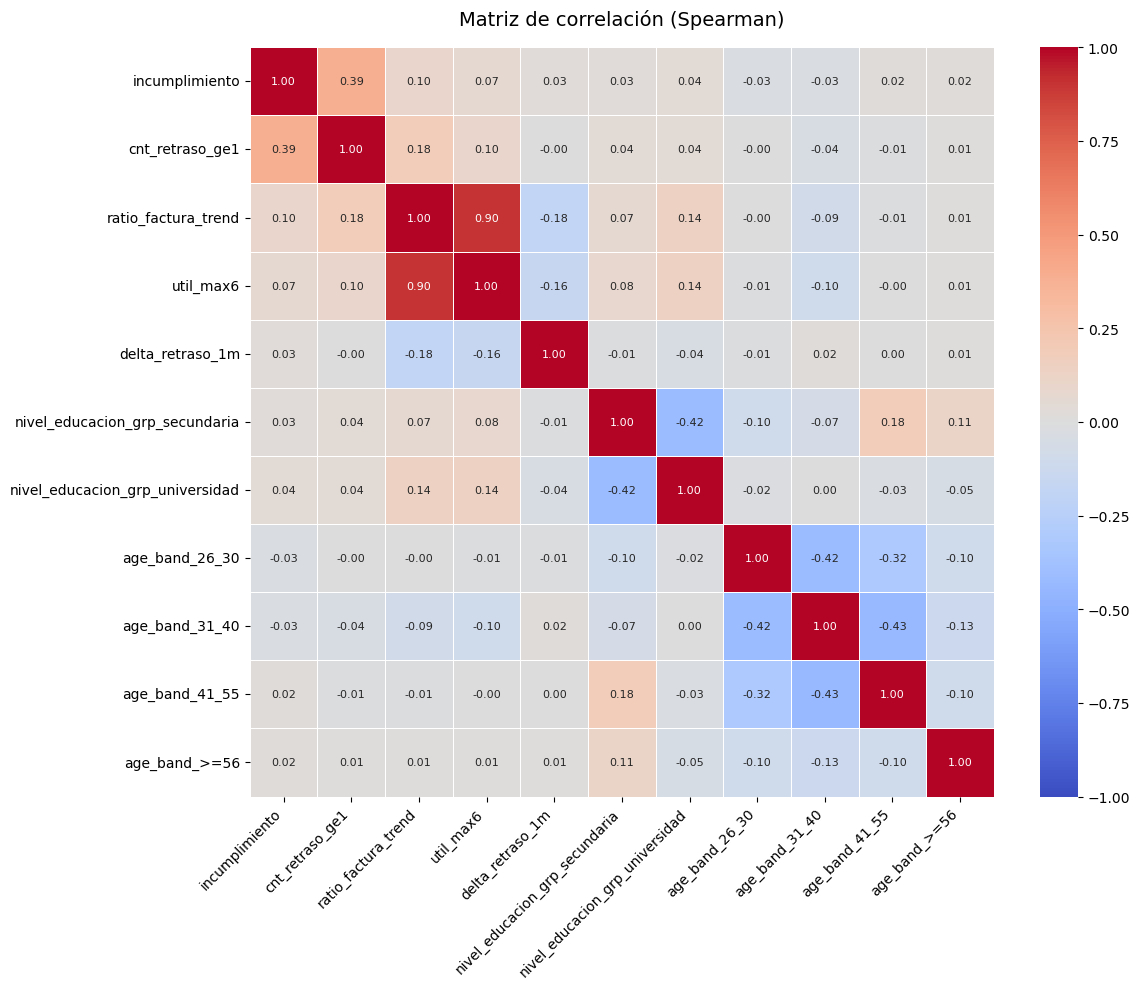

In [ ]:
# Configuración de DataFrame para análisis de correlación

df = df_feat.copy()
target = 'incumplimiento'
id_col = 'cliente_id'

# Seleccionando solo las columnas numéricas
num_df = df.select_dtypes(include='number').drop(columns=[id_col])

# Calculando matriz de correlación (Spearman recomendado)
corr = num_df.corr(method='spearman').round(2)


# Tamaño de la figura proporcional al nº de variables
fig, ax = plt.subplots(figsize=(12, 10))

# Heatmap con una paleta divergente centrada en 0
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    annot=True,
    fmt='.2f',
    annot_kws={"size":8}
)

# Estética general
plt.title('Matriz de correlación (Spearman)', fontsize=14, pad=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Definiendo variables numéricas (excluyendo ID y target)

num_vars = df_feat.select_dtypes(include='number').columns.drop(['cliente_id', 'incumplimiento'])

# Calculando AUC univariante para cada variable
auc_scores = {}
for col in num_vars:
    try:
        auc = roc_auc_score(df_feat['incumplimiento'], df_feat[col])
        auc_scores[col] = auc
    except ValueError:
        # En caso de variables constantes o problemas de cálculo
        auc_scores[col] = float('nan')

# Organizando resultados en un DataFrame ordenado
auc_df = (
    pd.Series(auc_scores, name='AUC')
      .sort_values(ascending=False)
      .to_frame()
      .round(3)
)

# Mostrando la tabla de AUCs
print(auc_df)


                                   AUC
cnt_retraso_ge1                  0.726
ratio_factura_trend              0.567
util_max6                        0.549
nivel_educacion_grp_universidad  0.522
delta_retraso_1m                 0.517
nivel_educacion_grp_secundaria   0.512
age_band_41_55                   0.510
age_band_>=56                    0.504
age_band_26_30                   0.486
age_band_31_40                   0.483
